# 三 MNIST⼿写体数据集

## 0 数据生成

In [41]:
import typing
import torch
import numpy as np
import torch.nn as nn
import torch.functional as func
import matplotlib.pyplot as plt
import torch.utils.data as tata
import torchvision as tcvs
import torchvision.transforms as trans

devc = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
train_datasets = tcvs.datasets.MNIST(
    root="./data", train=True, download=True, transform=trans.ToTensor()
)
test_datasets = tcvs.datasets.MNIST(
    root="./data", train=False, download=True, transform=trans.ToTensor()
)


def train_iter(batch_size: int) -> tata.DataLoader:
    return tata.DataLoader(dataset=train_datasets, batch_size=batch_size, shuffle=True)


def test_iter(batch_size: int) -> tata.DataLoader:
    return tata.DataLoader(dataset=test_datasets, batch_size=batch_size, shuffle=False)

## 1 ⼿动实现前馈神经⽹络解决上述回归、⼆分类、多分类任务
分析实验结果并绘制训练集和测试集的loss曲线

In [43]:
class Model:
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        device: torch.device,
    ) -> None:
        self.w1 = torch.normal(
            mean=0,
            std=(2 / input_dim) ** 0.5,
            size=(input_dim, hidden_dim),
            requires_grad=True,
            device=device,
        )
        self.w2 = torch.normal(
            mean=0,
            std=(2 / hidden_dim) ** 0.5,
            size=(hidden_dim, output_dim),
            requires_grad=True,
            device=device,
        )
        self.b1 = torch.zeros(hidden_dim, requires_grad=True, device=device)
        self.b2 = torch.zeros(output_dim, requires_grad=True, device=device)

    def __call__(self, X: torch.Tensor) -> torch.Tensor:
        return self.forward(X)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        if X.dim() > 1:  # 如果X的维度大于1，将其展平为二维张量，以便进行矩阵乘法运算。
            X = X.flatten(start_dim=1)
        z1 = X @ self.w1 + self.b1
        a1 = torch.relu(z1)
        z2 = a1 @ self.w2 + self.b2
        # a2 = torch.softmax(z2, dim=1)
        a2 = z2  # 在loss内再实现softmax，提升数值稳定性
        return a2.squeeze(-1)   # 必要时压缩最后一维

    def parameters(self) -> list[torch.Tensor]:
        return [self.w1, self.w2, self.b1, self.b2]

In [44]:
class Loss:
    def crossEntropySoftMax(
        self, y_pred: torch.Tensor, y_true: torch.Tensor
    ) -> torch.Tensor:
        log_softmax = y_pred.log_softmax(dim=1)
        return -log_softmax[range(len(y_true)), y_true].mean()

    def calc(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return self.crossEntropySoftMax(y_pred, y_true)

In [45]:
class Optimizer:
    def __init__(self, model: Model, lr: float = 0.01):
        self.model = model
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for param in self.model.parameters():
                if param.grad is not None:
                    param.data -= self.lr * param.grad

    def zero_grad(self):
        with torch.no_grad():
            for param in self.model.parameters():
                if param.grad is not None:
                    param.grad.zero_()

In [46]:
def evaluate_loss(
    model: Model, loss: Loss, data_iter: tata.DataLoader, device: torch.device
) -> float:
    with torch.no_grad():
        total_num = 0
        total_loss = 0.0
        for features, labels in data_iter:
            features, labels = features.to(device), labels.to(device)
            predicts = model(features)
            total_num += len(labels)
            total_loss += loss.calc(predicts, labels).item() * len(labels)
        return total_loss / total_num

In [47]:
def train(
    num_epoches: int,
    model: Model,
    loss: Loss,
    optimizer: Optimizer,
    train_iter: tata.DataLoader,
    test_iter: tata.DataLoader,
    device: torch.device,
) -> tuple[list[float], list[float]]:
    train_loss_list, test_loss_list = [], []
    for epoch in range(num_epoches):
        total_num = 0
        train_loss_val = 0
        test_loss_val = 0
        for features, labels in train_iter:
            features, labels = features.to(device), labels.to(device)
            predicts = model(features)
            loss_val = loss.calc(predicts, labels)
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            with torch.no_grad():
                total_num += len(labels)
                train_loss_val += loss_val.item() * len(labels)
        train_loss_list.append(train_loss_val / total_num)
        test_loss_val = evaluate_loss(model, loss, test_iter, device)
        test_loss_list.append(test_loss_val)
        print(
            f"Epoch {epoch + 1}, train loss: {train_loss_list[-1]:.4f}, test loss: {test_loss_list[-1]:.4f}"
        )
    return train_loss_list, test_loss_list

Epoch 1, train loss: 1.6265, test loss: 1.0987
Epoch 2, train loss: 0.9087, test loss: 0.7270
Epoch 3, train loss: 0.6715, test loss: 0.5809
Epoch 4, train loss: 0.5636, test loss: 0.5041
Epoch 5, train loss: 0.5019, test loss: 0.4571
Epoch 6, train loss: 0.4616, test loss: 0.4248
Epoch 7, train loss: 0.4330, test loss: 0.4012
Epoch 8, train loss: 0.4113, test loss: 0.3828
Epoch 9, train loss: 0.3940, test loss: 0.3685
Epoch 10, train loss: 0.3799, test loss: 0.3566
Epoch 11, train loss: 0.3680, test loss: 0.3460
Epoch 12, train loss: 0.3578, test loss: 0.3371
Epoch 13, train loss: 0.3487, test loss: 0.3299
Epoch 14, train loss: 0.3407, test loss: 0.3223
Epoch 15, train loss: 0.3335, test loss: 0.3156
Epoch 16, train loss: 0.3269, test loss: 0.3100
Epoch 17, train loss: 0.3209, test loss: 0.3051
Epoch 18, train loss: 0.3152, test loss: 0.2999
Epoch 19, train loss: 0.3100, test loss: 0.2953
Epoch 20, train loss: 0.3050, test loss: 0.2912
Epoch 21, train loss: 0.3004, test loss: 0.2870
E

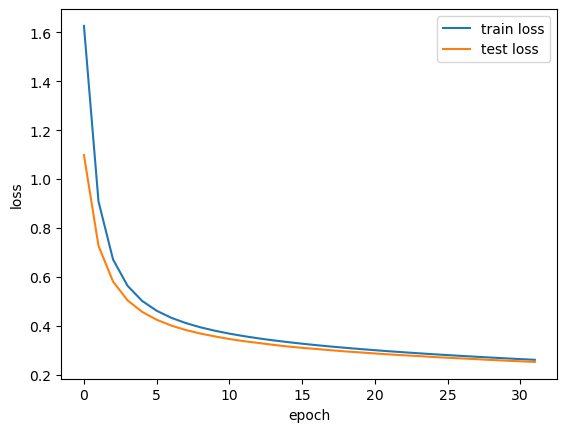

In [48]:
num_epoches = 32
input_dim = 1 * 28 * 28
hidden_dim = 256
output_dim = 10
model = Model(input_dim, hidden_dim, output_dim, devc)
loss = Loss()
lr = 0.03
optimizer = Optimizer(model, lr)
batch_size = 1024
train_loader = train_iter(batch_size)
test_loader = test_iter(batch_size)

train_loss_list, test_loss_list = train(
    num_epoches, model, loss, optimizer, train_loader, test_loader, devc
)

plt.plot(train_loss_list, label="train loss")
plt.plot(test_loss_list, label="test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

## 2 利⽤torch.nn实现前馈神经⽹络解决上述回归、⼆分类、多分类任务
分析实验结果并绘制训练集和测试集的loss曲线

In [49]:
class Model(nn.Module):
    def __init__(
        self, input_dim: int, hidden_dim: int, output_dim: int, device: torch.device
    ) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            # nn.Softmax(dim=1)
        ).to(device)
        for m in self.parameters():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data, nonlinearity="relu")
                nn.init.zeros_(m.bias.data)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.model(X).squeeze(-1)

In [50]:
class Loss:
    def __init__(self) -> None:
        self.criterion = nn.CrossEntropyLoss()

    def calc(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return self.criterion(y_pred, y_true)

In [51]:
class Optimizer:
    def __init__(self, model: Model, lr: float = 0.01) -> None:
        self.optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    def step(self) -> None:
        self.optimizer.step()

    def zero_grad(self) -> None:
        self.optimizer.zero_grad()

In [52]:
def evaluate_loss(
    model: Model, loss: Loss, data_loader: tata.DataLoader, device: torch.device
) -> float:
    model.eval()
    total_loss = 0.0
    total_num = 0
    with torch.no_grad():
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)

            predicts = model(features)
            loss_value = loss.calc(predicts, labels)

            total_num += len(labels)
            total_loss += loss_value.item() * len(labels)
        model.train()
        return total_loss / total_num

In [53]:
def train(
    num_epoches: int,
    model: Model,
    loss: Loss,
    optimizer: Optimizer,
    train_loader: tata.DataLoader,
    test_loader: tata.DataLoader,
    device: torch.device,
):
    train_loss_list, test_loss_list = [], []

    for epoch in range(num_epoches):
        model.train()
        total_num = 0
        train_loss_val = 0
        test_loss_val = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)

            predicts = model(features)
            loss_value = loss.calc(predicts, labels)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            with torch.no_grad():
                total_num += len(labels)
                train_loss_val += loss_value.item() * len(labels)
        train_loss_list.append(train_loss_val / total_num)
        test_loss_val = evaluate_loss(model, loss, test_loader, device)
        test_loss_list.append(test_loss_val)
        print(
            f"Epoch {epoch + 1}/{num_epoches}, Train Loss: {train_loss_list[-1]:.4f}, Test Loss: {test_loss_list[-1]:.4f}"
        )
    return train_loss_list, test_loss_list

Epoch 1/32, Train Loss: 2.1160, Test Loss: 1.8660
Epoch 2/32, Train Loss: 1.5770, Test Loss: 1.2612
Epoch 3/32, Train Loss: 1.0758, Test Loss: 0.8875
Epoch 4/32, Train Loss: 0.8082, Test Loss: 0.7025
Epoch 5/32, Train Loss: 0.6685, Test Loss: 0.5991
Epoch 6/32, Train Loss: 0.5852, Test Loss: 0.5335
Epoch 7/32, Train Loss: 0.5302, Test Loss: 0.4881
Epoch 8/32, Train Loss: 0.4913, Test Loss: 0.4560
Epoch 9/32, Train Loss: 0.4623, Test Loss: 0.4310
Epoch 10/32, Train Loss: 0.4399, Test Loss: 0.4117
Epoch 11/32, Train Loss: 0.4220, Test Loss: 0.3959
Epoch 12/32, Train Loss: 0.4072, Test Loss: 0.3831
Epoch 13/32, Train Loss: 0.3949, Test Loss: 0.3723
Epoch 14/32, Train Loss: 0.3845, Test Loss: 0.3632
Epoch 15/32, Train Loss: 0.3754, Test Loss: 0.3548
Epoch 16/32, Train Loss: 0.3673, Test Loss: 0.3476
Epoch 17/32, Train Loss: 0.3601, Test Loss: 0.3412
Epoch 18/32, Train Loss: 0.3537, Test Loss: 0.3356
Epoch 19/32, Train Loss: 0.3478, Test Loss: 0.3302
Epoch 20/32, Train Loss: 0.3423, Test Lo

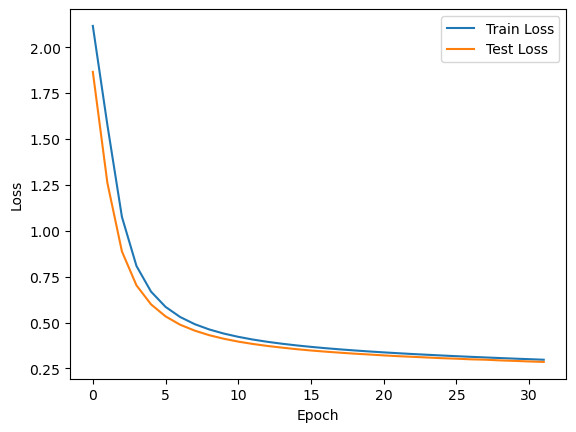

In [54]:
num_epoches = 32
input_dim = 1 * 28 * 28
hidden_dim = 256
output_dim = 10
model = Model(input_dim, hidden_dim, output_dim, devc)
loss = Loss()
lr = 0.03
optimizer = Optimizer(model, lr)
batch_size = 1024
train_loader = train_iter(batch_size)
test_loader = test_iter(batch_size)

train_loss_list, test_loss_list = train(
    num_epoches, model, loss, optimizer, train_loader, test_loader, devc
)

plt.plot(train_loss_list, label="Train Loss")
plt.plot(test_loss_list, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()